In [1]:
import pygrib
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
def print_grbs(grbs):
    """
    prints the contents of a pygrib.open(filename) variable
    """
    for grb in grbs:
        print(grb)

In [3]:
satdata_2017_01_01_00_0 = "mod/moddata/nam_218_20170101_0000_000.grb2"
grbs = pygrib.open(satdata_2017_01_01_00_0)
print(grbs)

In [4]:
print_grbs(grbs)

1:MSLP (Eta model reduction):Pa (instant):lambert:meanSea:level 0:fcst time 0 hrs:from 201701010000
2:Pressure reduced to MSL:Pa (instant):lambert:meanSea:level 0:fcst time 0 hrs:from 201701010000
3:Surface pressure:Pa (instant):lambert:surface:level 0:fcst time 0 hrs:from 201701010000
4:Orography:m (instant):lambert:surface:level 0:fcst time 0 hrs:from 201701010000
5:Temperature:K (instant):lambert:surface:level 0:fcst time 0 hrs:from 201701010000
6:2 metre temperature:K (instant):lambert:heightAboveGround:level 2 m:fcst time 0 hrs:from 201701010000
7:2 metre dewpoint temperature:K (instant):lambert:heightAboveGround:level 2 m:fcst time 0 hrs:from 201701010000
8:2 metre relative humidity:% (instant):lambert:heightAboveGround:level 2 m:fcst time 0 hrs:from 201701010000
9:10 metre U wind component:m s**-1 (instant):lambert:heightAboveGround:level 10 m:fcst time 0 hrs:from 201701010000
10:10 metre V wind component:m s**-1 (instant):lambert:heightAboveGround:level 10 m:fcst time 0 hrs:fro

125:Relative humidity:% (instant):lambert:isobaricInhPa:level 32500 Pa:fcst time 0 hrs:from 201701010000
126:U component of wind:m s**-1 (instant):lambert:isobaricInhPa:level 32500 Pa:fcst time 0 hrs:from 201701010000
127:V component of wind:m s**-1 (instant):lambert:isobaricInhPa:level 32500 Pa:fcst time 0 hrs:from 201701010000
128:Turbulent kinetic energy:J kg**-1 (instant):lambert:isobaricInhPa:level 32500 Pa:fcst time 0 hrs:from 201701010000
129:Geopotential Height:gpm (instant):lambert:isobaricInhPa:level 35000 Pa:fcst time 0 hrs:from 201701010000
130:Temperature:K (instant):lambert:isobaricInhPa:level 35000 Pa:fcst time 0 hrs:from 201701010000
131:Relative humidity:% (instant):lambert:isobaricInhPa:level 35000 Pa:fcst time 0 hrs:from 201701010000
132:U component of wind:m s**-1 (instant):lambert:isobaricInhPa:level 35000 Pa:fcst time 0 hrs:from 201701010000
133:V component of wind:m s**-1 (instant):lambert:isobaricInhPa:level 35000 Pa:fcst time 0 hrs:from 201701010000
134:Turbule

266:Turbulent kinetic energy:J kg**-1 (instant):lambert:isobaricInhPa:level 90000 Pa:fcst time 0 hrs:from 201701010000
267:Geopotential Height:gpm (instant):lambert:isobaricInhPa:level 92500 Pa:fcst time 0 hrs:from 201701010000
268:Temperature:K (instant):lambert:isobaricInhPa:level 92500 Pa:fcst time 0 hrs:from 201701010000
269:Relative humidity:% (instant):lambert:isobaricInhPa:level 92500 Pa:fcst time 0 hrs:from 201701010000
270:U component of wind:m s**-1 (instant):lambert:isobaricInhPa:level 92500 Pa:fcst time 0 hrs:from 201701010000
271:V component of wind:m s**-1 (instant):lambert:isobaricInhPa:level 92500 Pa:fcst time 0 hrs:from 201701010000
272:Turbulent kinetic energy:J kg**-1 (instant):lambert:isobaricInhPa:level 92500 Pa:fcst time 0 hrs:from 201701010000
273:Geopotential Height:gpm (instant):lambert:isobaricInhPa:level 95000 Pa:fcst time 0 hrs:from 201701010000
274:Temperature:K (instant):lambert:isobaricInhPa:level 95000 Pa:fcst time 0 hrs:from 201701010000
275:Relative hu

342:V component of wind:m s**-1 (instant):lambert:tropopause:level 0:fcst time 0 hrs:from 201701010000
343:Vertical u-component shear:s**-1 (instant):lambert:heightAboveGroundLayer:levels 6000-0 m:fcst time 0 hrs:from 201701010000
344:Vertical v-component shear:s**-1 (instant):lambert:heightAboveGroundLayer:levels 6000-0 m:fcst time 0 hrs:from 201701010000
345:Pressure:Pa (instant):lambert:maxWind:level 0:fcst time 0 hrs:from 201701010000
346:U component of wind:m s**-1 (instant):lambert:maxWind:level 0:fcst time 0 hrs:from 201701010000
347:V component of wind:m s**-1 (instant):lambert:maxWind:level 0:fcst time 0 hrs:from 201701010000
348:Storm relative helicity:J kg**-1 (instant):lambert:heightAboveGroundLayer:levels 3000-0 m:fcst time 0 hrs:from 201701010000
349:Visibility:m (instant):lambert:surface:level 0:fcst time 0 hrs:from 201701010000
350:Precipitable water:kg m**-2 (instant):lambert:unknown:level 0 200:fcst time 0 hrs:from 201701010000
351:Geopotential Height:gpm (instant):la

In [5]:
temp = grbs.select(name="Temperature")[0].values

In [6]:
print(temp)

[[300.16950989 300.04450989 300.04450989 ... 301.29450989 301.04450989
  300.91950989]
 [300.04450989 300.16950989 300.04450989 ... 301.04450989 301.04450989
  301.04450989]
 [299.79450989 300.04450989 300.29450989 ... 300.91950989 301.16950989
  300.91950989]
 ...
 [278.54450989 278.66950989 278.66950989 ... 276.54450989 276.66950989
  276.79450989]
 [278.66950989 278.66950989 278.79450989 ... 276.79450989 276.79450989
  276.79450989]
 [278.66950989 278.54450989 278.54450989 ... 276.79450989 276.91950989
  276.79450989]]


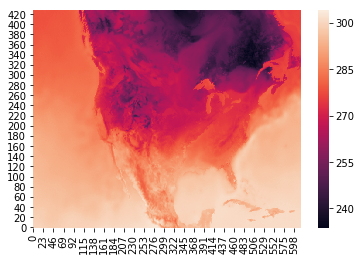

In [11]:
plt.figure()
ax = sns.heatmap(temp, cbar='true')
ax.invert_yaxis()